In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 5
%autosave 15 

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

Autosaving every 15 seconds


In [2]:
USERS = pd.read_csv('users.csv')
GAME_RESULTS = pd.read_csv('game_results.csv')
PREDICTIONS = pd.read_csv('predictions.csv')
print('users:', list(USERS.columns), USERS.shape[0])
print('game_results:', list(GAME_RESULTS.columns), GAME_RESULTS.shape[0])
print('unique users in game results:', GAME_RESULTS['user_id'].unique().shape[0])
print('predictions:', list(PREDICTIONS.columns), PREDICTIONS.shape[0])


users: ['id', 'create_time'] 4899
game_results: ['id', 'user_id', 'timestamp', 'winner', 'length', 'magic_used', 'player_cards', 'round', 'type'] 812733
unique users in game results: 5289
predictions: ['id', 'prediction'] 4000


Оставим только игры, совершенные в первые сутки после регистрации пользователя.

In [3]:
data = GAME_RESULTS.merge(USERS, left_on='user_id', right_on='id', how='left')
data.drop(['id_x', 'id_y'], axis=1, inplace=True)
data.rename({'create_time': 'registration_time'}, axis=1, inplace=True)

data['first_day'] = (pd.to_datetime(data['timestamp']) - pd.to_datetime(data['registration_time'])).dt.days < 1

data = data[data['first_day']]
data.head()
print('data:', data.shape)

data: (63370, 10)


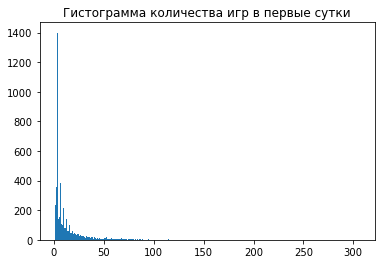

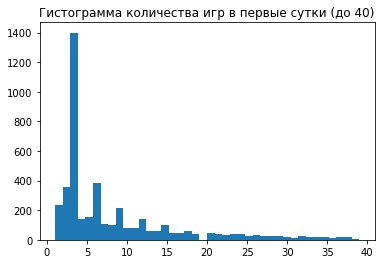

count    4670.000000
mean       13.569593
std        22.621164
min         1.000000
25%         3.000000
50%         6.000000
75%        14.000000
max       306.000000
Name: timestamp, dtype: float64


In [4]:
users = data.groupby('user_id').count()

plt.hist(users['timestamp'], bins=users['timestamp'].max() - users['timestamp'].min() + 1)
plt.title('Гистограмма количества игр в первые сутки')
plt.show()

plt.hist(users[users['timestamp'] < 40]['timestamp'], bins=40)
plt.title('Гистограмма количества игр в первые сутки (до 40)')
plt.show()

print(users['timestamp'].describe())

Посчитаем для каждого пользователя количество игр, побед, пораждений, винрейт, среднюю продолжителньость игры, суммарное использование магии, максимальное количество магии в одной игре, среднее количество карт к концу игры, количество игр в каждом из четырех типов за первые сутки.

In [5]:
users = pd.get_dummies(data, columns=['type']).groupby('user_id').agg(
    games = pd.NamedAgg(column = 'timestamp', aggfunc = 'count'),
    wins = pd.NamedAgg(column = 'winner', aggfunc = 'sum'),
    win_rate = pd.NamedAgg(column = 'winner', aggfunc = 'mean'),
    length_mean = pd.NamedAgg(column = 'length', aggfunc = 'mean'),
    magic_total = pd.NamedAgg(column = 'magic_used', aggfunc = 'sum'),
    magic_max = pd.NamedAgg(column = 'magic_used', aggfunc = 'max'),
    cards_mean = pd.NamedAgg(column = 'player_cards', aggfunc = 'mean'),
    tournaments = pd.NamedAgg(column = 'type_1', aggfunc = 'sum'),
    worlds_tours = pd.NamedAgg(column = 'type_2', aggfunc = 'sum'),
    trainings = pd.NamedAgg(column = 'type_3', aggfunc = 'sum'),
    practices = pd.NamedAgg(column = 'type_4', aggfunc = 'sum'),
    )
users['loses'] = users['games'] - users['wins']

users.reset_index(inplace=True)
users

train_users = users[users['user_id'].isin(PREDICTIONS['id'])].merge(PREDICTIONS, left_on='user_id',
                                                                    right_on='id', how='left').drop(['id'], axis=1)
test_users = users[users['user_id'].isin(PREDICTIONS['id']) == 0]

print('users:', users.shape[0])
print('train users:', train_users.shape[0])
print('test users:', test_users.shape[0])

users: 4670
train users: 3821
test users: 849


In [6]:
users.to_csv('user_features.csv', index=False)
users.describe()

,user_id,games,wins,win_rate,length_mean,magic_total,magic_max,cards_mean,tournaments,worlds_tours,trainings,practices,loses
count,4670.000000,4670.000000,4670.000000,4670.000000,4670.000000,4670.000000,4670.000000,4670.000000,4670.000000,4670.000000,4670.000000,4670.000000,4670.000000
mean,226335.959529,13.569593,11.750535,0.815967,267.074518,8.878373,3.209850,32.638624,12.479657,1.016488,0.065953,0.007495,1.819058
std,4676.880934,22.621164,19.499138,0.253692,184.588040,8.355264,2.494558,12.969708,18.627801,7.026732,0.771034,0.284058,3.451221
min,218490.000000,1.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,222333.250000,3.000000,3.000000,0.750000,193.666667,2.000000,1.000000,25.777778,3.000000,0.000000,0.000000,0.000000,0.000000
50%,226163.500000,6.000000,5.000000,0.894737,245.083333,7.000000,3.000000,33.321839,6.000000,0.000000,0.000000,0.000000,1.000000
75%,230355.750000,14.000000,12.000000,1.000000,311.984375,15.000000,5.000000,41.666667,14.000000,0.000000,0.000000,0.000000,2.000000
max,234754.000000,306.000000,260.000000,1.000000,9865.000000,141.000000,25.000000,52.000000,220.000000,209.000000,29.000000,16.000000,46.000000


In [7]:
train_users.drop(['user_id'], axis=1).corr().style.background_gradient(cmap='coolwarm')

,games,wins,win_rate,length_mean,magic_total,magic_max,cards_mean,tournaments,worlds_tours,trainings,practices,loses,prediction
games,1.000000,0.997737,0.116371,-0.079097,0.559409,0.175338,-0.065870,0.957931,0.669042,0.163119,0.079978,0.924193,-0.240194
wins,0.997737,1.000000,0.149857,-0.088071,0.561110,0.173817,-0.045320,0.957848,0.664124,0.146004,0.075998,0.896420,-0.242272
win_rate,0.116371,0.149857,1.000000,-0.042725,0.238354,0.230653,0.581751,0.132090,0.027489,-0.006259,0.000329,-0.084147,-0.113968
length_mean,-0.079097,-0.088071,-0.042725,1.000000,0.024197,0.075071,-0.036610,-0.074640,-0.057514,0.003313,-0.009381,-0.021111,-0.015950
magic_total,0.559409,0.561110,0.238354,0.024197,1.000000,0.699231,0.179563,0.576871,0.269368,0.079135,0.039424,0.500149,-0.243092
magic_max,0.175338,0.173817,0.230653,0.075071,0.699231,1.000000,0.267980,0.191358,0.055085,0.045155,0.005447,0.168432,-0.101317
cards_mean,-0.065870,-0.045320,0.581751,-0.036610,0.179563,0.267980,1.000000,-0.065730,-0.033626,-0.042997,-0.006387,-0.176752,-0.015614
tournaments,0.957931,0.957848,0.132090,-0.074640,0.576871,0.191358,-0.065730,1.000000,0.430229,0.138887,0.045425,0.873471,-0.258718
worlds_tours,0.669042,0.664124,0.027489,-0.057514,0.269368,0.055085,-0.033626,0.430229,1.000000,0.046555,0.091885,0.637655,-0.086753
trainings,0.163119,0.146004,-0.006259,0.003313,0.079135,0.045155,-0.042997,0.138887,0.046555,1.000000,0.016985,0.245869,-0.036209


In [8]:
train_users

,user_id,games,wins,win_rate,length_mean,magic_total,magic_max,cards_mean,tournaments,worlds_tours,trainings,practices,loses,prediction
0,218490,38,31,0.815789,562.421053,23,7,26.447368,38,0,0,0,7,0
1,218493,7,4,0.571429,471.142857,16,8,41.428571,7,0,0,0,3,1
2,218499,3,3,1.000000,115.666667,0,0,24.333333,3,0,0,0,0,0
3,218507,4,3,0.750000,181.000000,10,7,39.000000,4,0,0,0,1,1
4,218508,12,11,0.916667,287.250000,20,6,36.500000,12,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3816,234738,3,2,0.666667,178.333333,0,0,4.000000,3,0,0,0,1,1
3817,234743,5,4,0.800000,196.200000,10,3,40.000000,5,0,0,0,1,1
3818,234752,70,63,0.900000,145.642857,0,0,24.900000,70,0,0,0,7,0
3819,234753,3,2,0.666667,270.000000,0,0,6.000000,3,0,0,0,1,1


Обучим random forest классификатор, количество деревьев и максимальная глубина получены перебором, качество оценивалось по наибольшему rocauc на кроссвалидации при 6 фолдах.

In [9]:
kfold = StratifiedKFold(6, random_state=42, shuffle=True)
X = train_users.drop(['user_id', 'prediction'], axis=1)
y = train_users['prediction']
scores_train = []
scores_test = []
for train_index, test_index in kfold.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    rf = RandomForestClassifier(random_state=42, n_estimators=10000, n_jobs=-1, max_depth=5)
    rf.fit(X_train, y_train)
    y_pred_train = rf.predict_proba(X_train).T[1].T
    y_pred_test = rf.predict_proba(X_test).T[1].T
    score_train = roc_auc_score(y_train, y_pred_train)
    score_test = roc_auc_score(y_test, y_pred_test)
    print(score_train, score_test)
    scores_train.append(score_train)
    scores_test.append(score_test)
print('train:', np.mean(scores_train), 'test:', np.mean(scores_test))

rf = RandomForestClassifier(random_state=42, n_estimators=10000, n_jobs=-1, max_depth=5)
rf.fit(X, y)
X_test = test_users.copy()
pred = rf.predict(X_test.drop(['user_id'], axis=1))
proba = rf.predict_proba(X_test.drop(['user_id'], axis=1)).T[1].T
X_test['prediction'] = pred
X_test['proba'] = proba

0.7732368518819297 0.7275591653829996
0.7713328460721334 0.731351818139383
0.7723687428474348 0.7206156934136209
0.7693676992496925 0.7316960743126546
0.7767904134570257 0.7088908798957436
0.7717911468523769 0.723610802465526
train: 0.7724812833934322 test: 0.7239540722683212


In [10]:
X_test[['user_id', 'prediction', 'proba']].to_csv('new_predictions.csv', index=False)